## IMDB Dataset Analysis with Apache Spark

The Dataset of Imdb is analysed using apache spark and RDD(Resilent Distributed Dataset). There are two .tsv files.
1. Titles
2. Rating

The dataset is downloaded from: https://www.imdb.com/interfaces/

Titles: This tsv file contains all details related with the movies and is a massive dataset with 50M records.<br> Rating: This tsv file contains average rating of some movies.

In [11]:
import pyspark as ps
from pyspark import SparkContext,SparkConf
from pyspark.sql import SparkSession
import pyspark.java_gateway
from pyspark.sql.functions import desc
from pyspark.sql.functions import rand
from pyspark.sql import Row as row
import pandas as pd
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
import matplotlib.pyplot as plt
import numpy
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.classification import SVMWithSGD,LogisticRegressionWithLBFGS
from pyspark.ml.evaluation import RegressionEvaluator

In [12]:
conf=SparkConf().setAppName("Imdb data Analysis")
spark = SparkSession.builder.appName('Imdb').getOrCreate()

In [13]:
titles = sc.textFile('/home/prakass1/imdb_dataset/data_title.tsv').cache()
rating = sc.textFile('/home/prakass1/imdb_dataset/data_rating.tsv').cache()

In [14]:
def parse_data(line):
    data = line.split('\t')
    line = row(movieId = str(data[0]), movieType=str(data[1]), movieName = str(data[2]), genre = str(data[8]),runningTime=str(data[7]))
    return line

In [15]:
def parse_rating(line):
    data = line.split('\t')
    line = row(movieId = str(data[0]), avgRating=float(data[1]), votes = int(data[2]))
    return line

In [16]:
def filter_header(data):
    header = data.first()
    data = data.filter(lambda line: line !=header)
    return data

In [17]:
def parse_rating_data(line):
    data = line.split('\t')
    row = data[0] + "," + data[1] + "," + data[2]
    return row

In [18]:
def perform_title_mapping(lines):
    rows = lines.map(parse_data)
    return rows

In [19]:
def perform_rating_mapping(lines):
    rows = lines.map(parse_rating)
    return rows

In [20]:
#Filter the first header (Assumption made that header is always the first row)
titles_rows = filter_header(titles)
rating_rows = filter_header(rating)

In [21]:
#Perform mapping for the rows of data
titles = perform_title_mapping(titles_rows)
rating = perform_rating_mapping(rating_rows)

In [22]:
titles.take(2)

[Row(genre='Documentary,Short', movieId='tt0000001', movieName='Carmencita', movieType='short', runningTime='1'),
 Row(genre='Animation,Short', movieId='tt0000002', movieName='Le clown et ses chiens', movieType='short', runningTime='5')]

In [23]:
df_titles = spark.createDataFrame(titles)
df_rating = spark.createDataFrame(rating)

In [24]:
#df_titles.describe().show()

In [25]:
#Partition Both RDD
#df_titles.head(5)

In [26]:
#Describe the data of Titles
df_titles.printSchema()

root
 |-- genre: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- movieName: string (nullable = true)
 |-- movieType: string (nullable = true)
 |-- runningTime: string (nullable = true)



In [27]:
#df_rating.head(5)

In [28]:
#Describe the data of Rating
df_rating.printSchema()

root
 |-- avgRating: double (nullable = true)
 |-- movieId: string (nullable = true)
 |-- votes: long (nullable = true)



In [29]:
#df_rating.count()

838182

In [211]:
#df_titles.count()

5040244

In [30]:
#Order the rating in the descending order of rating
grouped_data = df_rating.orderBy(desc('votes'))

In [31]:
#Only get type as movie
cachedTitles = df_titles.filter(df_titles.movieType=='movie').select('movieId','movieName','genre').cache()
#cachedTitles.count()
cachedTitles.movieId

Column<b'movieId'>

In [32]:
#Get only the top ten movies
topTenMovies= grouped_data.select('movieId','votes','avgRating').take(10)
topTenMovies

[Row(movieId='tt0111161', votes=1957480, avgRating=9.3),
 Row(movieId='tt0468569', votes=1929695, avgRating=9.0),
 Row(movieId='tt1375666', votes=1714048, avgRating=8.8),
 Row(movieId='tt0137523', votes=1569401, avgRating=8.8),
 Row(movieId='tt0110912', votes=1530948, avgRating=8.9),
 Row(movieId='tt0109830', votes=1486730, avgRating=8.8),
 Row(movieId='tt0120737', votes=1414976, avgRating=8.8),
 Row(movieId='tt0133093', votes=1407146, avgRating=8.7),
 Row(movieId='tt0167260', votes=1397414, avgRating=8.9),
 Row(movieId='tt0068646', votes=1340046, avgRating=9.2)]

In [33]:
votes=[]
for movie in topTenMovies:
    votes.append(movie[1])
votes

[1957480,
 1929695,
 1714048,
 1569401,
 1530948,
 1486730,
 1414976,
 1407146,
 1397414,
 1340046]

In [34]:
rating=[]
for movie in topTenMovies:
    rating.append(movie[2])
rating

[9.3, 9.0, 8.8, 8.8, 8.9, 8.8, 8.8, 8.7, 8.9, 9.2]

In [36]:
groupTitle = df_titles.orderBy('movieId')

In [37]:
#Collect all data for top ten movies
titles=[]
for movies in topTenMovies:
    titles.append(cachedTitles.filter((cachedTitles.movieId == movies[0])).collect())
titles

[[Row(movieId='tt0111161', movieName='The Shawshank Redemption', genre='Crime,Drama')],
 [Row(movieId='tt0468569', movieName='The Dark Knight', genre='Action,Crime,Drama')],
 [Row(movieId='tt1375666', movieName='Inception', genre='Action,Adventure,Sci-Fi')],
 [Row(movieId='tt0137523', movieName='Fight Club', genre='Drama')],
 [Row(movieId='tt0110912', movieName='Pulp Fiction', genre='Crime,Drama')],
 [Row(movieId='tt0109830', movieName='Forrest Gump', genre='Drama,Romance')],
 [Row(movieId='tt0120737', movieName='The Lord of the Rings: The Fellowship of the Ring', genre='Adventure,Drama,Fantasy')],
 [Row(movieId='tt0133093', movieName='The Matrix', genre='Action,Sci-Fi')],
 [Row(movieId='tt0167260', movieName='The Lord of the Rings: The Return of the King', genre='Adventure,Drama,Fantasy')],
 [Row(movieId='tt0068646', movieName='The Godfather', genre='Crime,Drama')]]

In [38]:
movieNames=[]
genre=[]
for movie in titles:
    movieNames.append(movie[0][1])
    genre.append(movie[0][2])

In [39]:
print(movieNames)

['The Shawshank Redemption', 'The Dark Knight', 'Inception', 'Fight Club', 'Pulp Fiction', 'Forrest Gump', 'The Lord of the Rings: The Fellowship of the Ring', 'The Matrix', 'The Lord of the Rings: The Return of the King', 'The Godfather']


In [40]:
print(genre)

['Crime,Drama', 'Action,Crime,Drama', 'Action,Adventure,Sci-Fi', 'Drama', 'Crime,Drama', 'Drama,Romance', 'Adventure,Drama,Fantasy', 'Action,Sci-Fi', 'Adventure,Drama,Fantasy', 'Crime,Drama']


## TOP TEN GENRE BY AVERAGE RATING

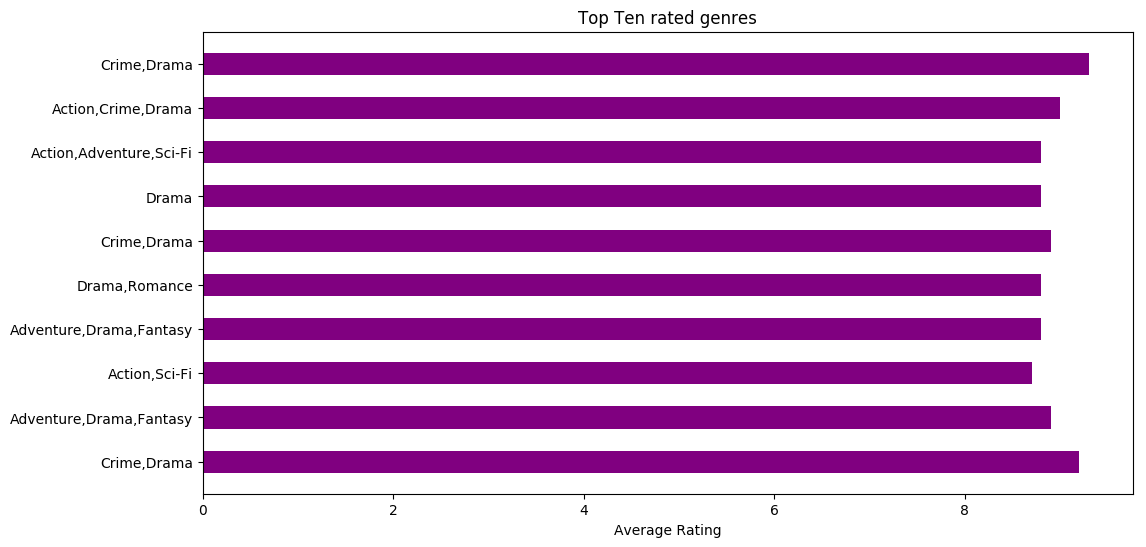

In [41]:
plt.rcdefaults()
fig,ax = plt.subplots(figsize=(12, 6))

# Example data
genres = genre
y_pos = numpy.arange(len(genres))
width = 0.5
ax.barh(y_pos, rating,width, align='center',
        color='purple')
ax.set_yticks(y_pos)
ax.set_yticklabels(genres)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Rating')
ax.set_title('Top Ten rated genres')

plt.show()

## TOP TEN MOVIES BY VOTES

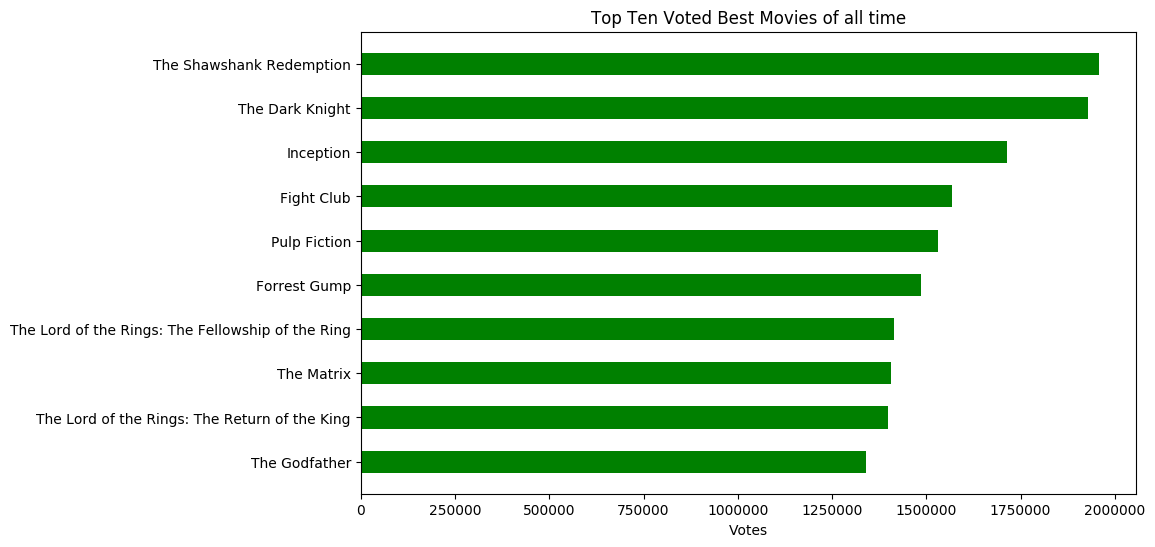

In [42]:
plt.rcdefaults()
fig,ax = plt.subplots(figsize=(10, 6))

# Example data
movies = movieNames
y_pos = numpy.arange(len(movies))
width = 0.5
ax.barh(y_pos, votes,width, align='center',
        color='green')
ax.set_yticks(y_pos)
ax.set_yticklabels(movies)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Votes')
ax.set_title('Top Ten Voted Best Movies of all time')

plt.show()

#### Get Count of Movies by Genre

In [43]:
genreMovieList=[]
genreMovieList.append(cachedTitles.filter(cachedTitles.genre.contains("Action")).collect())

In [44]:
print("The count of Action Movies are:" + str(len(genreMovieList[0])))

The count of Action Movies are:39832


#### Get 5 movies which start with a pattern

In [51]:
movie = "Batman"
cachedTitles.filter(cachedTitles.movieName.contains(movie)).take(10)

[Row(movieId='tt0035665', movieName='Batman', genre='Action,Adventure,Crime'),
 Row(movieId='tt0041162', movieName='Batman and Robin', genre='Action,Adventure,Crime'),
 Row(movieId='tt0057875', movieName='Batman Dracula', genre='Drama'),
 Row(movieId='tt0060153', movieName='Batman: The Movie', genre='Adventure,Comedy,Crime'),
 Row(movieId='tt0061386', movieName='Batman Fights Dracula', genre='Comedy'),
 Row(movieId='tt0096895', movieName='Batman', genre='Action,Adventure'),
 Row(movieId='tt0103776', movieName='Batman Returns', genre='Action,Crime,Fantasy'),
 Row(movieId='tt0106364', movieName='Batman: Mask of the Phantasm', genre='Action,Adventure,Animation'),
 Row(movieId='tt0112462', movieName='Batman Forever', genre='Action,Adventure,Fantasy'),
 Row(movieId='tt0118688', movieName='Batman & Robin', genre='Action,Sci-Fi')]

### Make a Prediction based on the running time of the movie into categories like movie and short videos

Decision Trees is used for the purposes since the features is continuos and decision tree is very robust to noise

In [54]:
#Take titles in a random order to train
randomizedTitle = df_titles.orderBy(rand())

In [53]:
randomizedTitle.printSchema()

root
 |-- genre: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- movieName: string (nullable = true)
 |-- movieType: string (nullable = true)
 |-- runningTime: string (nullable = true)



In [55]:
#Drop NULL and get the titles which are according to the label
#randomizedTitle = randomizedTitle.dropDuplicates()
labels = ["short","movie"]
titles = randomizedTitle.filter((randomizedTitle.movieType != '\\N' ) & 
                                (randomizedTitle.runningTime != '\\N'))

In [56]:
#Get selectedTitles of the label type
selectedTitles = titles.filter(titles.movieType.contains("short") |
                              titles.movieType.contains("movie"))
selectedTitles.take(2)

[Row(genre='Documentary,Short', movieId='tt4196798', movieName="Madeleine L'Engle: Star Gazer", movieType='short', runningTime='30'),
 Row(genre='\\N', movieId='tt0093234', movieName='Hotel de France', movieType='movie', runningTime='98')]

In [57]:
dataset = selectedTitles.take(2000)

In [58]:
#Creating a training and test dataset out of the large data
filterDataSet = []
#Filter columns
for titles in dataset:
    filterDataSet.append(titles[3:])
    
range = int(len(filterDataSet)*(2/3))
#Make a train and test set
train = filterDataSet[0:range]
test = filterDataSet[len(train):]

In [59]:
#Creating features to feed into a machine learning algorithm
x=[]
y=[]
for data in filterDataSet:
    x.append(data[1])
    y.append(data[0])

In [60]:
len(train)

1333

In [61]:

len(test)

667

In [62]:
#train[0:]

In [63]:
def getLabelVal(line,flag):
    ordinalValues = {
    0:"short",
    #2:"tvEpisode",
    1:"movie"
}
    for key,val in ordinalValues.items():
        if(flag):
            if key == line:
                return val
        if val == line:
            return key

In [64]:
unique=[]
for line in train:
    if line[0] not in unique:
        unique.append(line[0])
unique

['short', 'movie']

In [65]:
def makeTrainData(line,flag=False):
    label = float(getLabelVal(line[0],flag))
    features = Vectors.dense(float(line[1]))
    return LabeledPoint(label, features)

In [66]:
labelTrainSet = []
for line in train:
    labelTrainSet.append(makeTrainData(line))
#labelTrainSet

In [67]:
labelTestSet = []
for line in test:
    labelTestSet.append(makeTrainData(line))
#labelTestSet

In [68]:
# Train a naive Bayes model.
trainSetRDD = sc.parallelize(labelTrainSet)
testSetRDD = sc.parallelize(labelTestSet)

trainSetRDD.take(30)

[LabeledPoint(0.0, [30.0]),
 LabeledPoint(1.0, [98.0]),
 LabeledPoint(1.0, [110.0]),
 LabeledPoint(0.0, [13.0]),
 LabeledPoint(1.0, [73.0]),
 LabeledPoint(0.0, [13.0]),
 LabeledPoint(1.0, [92.0]),
 LabeledPoint(0.0, [7.0]),
 LabeledPoint(0.0, [9.0]),
 LabeledPoint(0.0, [17.0]),
 LabeledPoint(0.0, [13.0]),
 LabeledPoint(1.0, [94.0]),
 LabeledPoint(1.0, [75.0]),
 LabeledPoint(1.0, [146.0]),
 LabeledPoint(0.0, [15.0]),
 LabeledPoint(0.0, [7.0]),
 LabeledPoint(0.0, [10.0]),
 LabeledPoint(0.0, [5.0]),
 LabeledPoint(1.0, [107.0]),
 LabeledPoint(1.0, [120.0]),
 LabeledPoint(0.0, [13.0]),
 LabeledPoint(1.0, [52.0]),
 LabeledPoint(0.0, [34.0]),
 LabeledPoint(1.0, [133.0]),
 LabeledPoint(0.0, [18.0]),
 LabeledPoint(0.0, [18.0]),
 LabeledPoint(0.0, [4.0]),
 LabeledPoint(1.0, [80.0]),
 LabeledPoint(0.0, [6.0]),
 LabeledPoint(0.0, [25.0])]

In [69]:
import pandas
from pandas.plotting import scatter_matrix

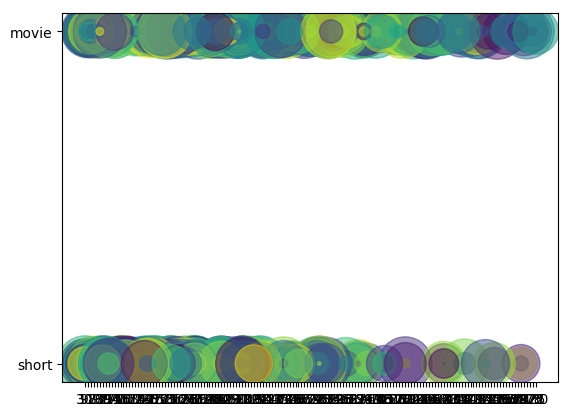

In [70]:
#A scatter of data points visualization
N = len(x)
x = x
y = y
colors = numpy.random.rand(N)
area = (40 * numpy.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()

In [74]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
# Train a DecisionTree model.
#  Empty categoricalFeaturesInfo indicates all features are continuous.
model = DecisionTree.trainClassifier(trainSetRDD, numClasses=3, categoricalFeaturesInfo={},
                                 impurity='entropy')

# Evaluate model on test instances and compute test error
predictions = model.predict(testSetRDD.map(lambda x: x.features))
labelsAndPredictions = testSetRDD.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda p:p[0]!=p[1]).count() / float(testSetRDD.count())
accuracy = labelsAndPredictions.filter(lambda p:p[0]==p[1]).count() / float(testSetRDD.count())
print('Test Error = ' + str(testErr))
print('Accuracy= ' + str(accuracy) )
print('Learned classification tree model:')
print(model.toDebugString())

Test Error = 0.017991004497751123
Accuracy= 0.9820089955022488
Learned classification tree model:
DecisionTreeModel classifier of depth 5 with 17 nodes
  If (feature 0 <= 44.0)
   If (feature 0 <= 15.5)
    If (feature 0 <= 13.5)
     If (feature 0 <= 3.5)
      Predict: 0.0
     Else (feature 0 > 3.5)
      If (feature 0 <= 12.5)
       Predict: 0.0
      Else (feature 0 > 12.5)
       Predict: 0.0
    Else (feature 0 > 13.5)
     Predict: 0.0
   Else (feature 0 > 15.5)
    If (feature 0 <= 29.5)
     If (feature 0 <= 16.5)
      Predict: 0.0
     Else (feature 0 > 16.5)
      If (feature 0 <= 25.5)
       Predict: 0.0
      Else (feature 0 > 25.5)
       Predict: 0.0
    Else (feature 0 > 29.5)
     Predict: 0.0
  Else (feature 0 > 44.0)
   Predict: 1.0



Py4JJavaError: An error occurred while calling z:org.apache.spark.mllib.tree.model.DecisionTreeModel.load.
: java.lang.UnsupportedOperationException: empty collection
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1374)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1371)
	at org.apache.spark.mllib.util.Loader$.loadMetadata(modelSaveLoad.scala:129)
	at org.apache.spark.mllib.tree.model.DecisionTreeModel$.load(DecisionTreeModel.scala:320)
	at org.apache.spark.mllib.tree.model.DecisionTreeModel.load(DecisionTreeModel.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
# Save and load model
model.save(sc, "/home/prakass1/myDecisionTreeClassificationModel-1")

In [90]:
val = int(model.predict([180.0]))
label = getLabelVal(val,flag=True)
val,label

(1, 'movie')

In [78]:
val = int(model.predict([20.0]))
label = getLabelVal(val,flag=True)
val,label

(0, 'short')

In [87]:
val = int(model.predict([10.0]))
label = getLabelVal(val,flag=True)
val,label

(0, 'short')

In [159]:
#sc.stop()